In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Thu Apr 20 20:19:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   38C    P8    19W / 140W |    548MiB / 16376MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# d-dimensional PDE

## Allen-Cahn

In [5]:
# function definition

def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def dgm_f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2



Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-133941-allen_cahn-T0.001-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-134425-tmp


Time taken: 284 seconds; L1 error: 4.12E-04; L2 error: 2.98E-07; rel error: 1.40E-03.
fdb runtime: 0 seconds; total runtime: 284 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 258 seconds; L1 error: 5.95E-03; L2 error: 4.68E-05; rel error: 1.75E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-135241-allen_cahn-T0.001-nu1.0


Time taken: 239 seconds; L1 error: 6.21E-04; L2 error: 5.42E-07; rel error: 1.87E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-135729-tmp


Time taken: 288 seconds; L1 error: 1.40E-03; L2 error: 3.53E-06; rel error: 8.61E-03.
fdb runtime: 0 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 250 seconds; L1 error: 1.91E-03; L2 error: 4.55E-06; rel error: 7.46E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-140539-allen_cahn-T0.001-nu1.0


Time taken: 240 seconds; L1 error: 4.06E-04; L2 error: 2.90E-07; rel error: 2.03E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-141025-tmp


Time taken: 286 seconds; L1 error: 1.56E-03; L2 error: 3.35E-06; rel error: 4.49E-03.
fdb runtime: 0 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 261 seconds; L1 error: 6.80E-03; L2 error: 5.17E-05; rel error: 2.61E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-141846-allen_cahn-T0.001-nu1.0


Time taken: 240 seconds; L1 error: 5.25E-04; L2 error: 3.69E-07; rel error: 1.63E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-142327-tmp


Time taken: 281 seconds; L1 error: 4.28E-04; L2 error: 2.72E-07; rel error: 1.25E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 263 seconds; L1 error: 7.86E-03; L2 error: 6.75E-05; rel error: 2.72E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-143151-allen_cahn-T0.001-nu1.0


Time taken: 241 seconds; L1 error: 6.08E-04; L2 error: 5.61E-07; rel error: 2.58E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-143640-tmp


Time taken: 288 seconds; L1 error: 8.81E-04; L2 error: 9.00E-07; rel error: 2.39E-03.
fdb runtime: 0 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 252 seconds; L1 error: 7.07E-03; L2 error: 6.20E-05; rel error: 3.27E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-144450-allen_cahn-T0.001-nu1.0


Time taken: 238 seconds; L1 error: 4.29E-04; L2 error: 2.39E-07; rel error: 1.60E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-144932-tmp


Time taken: 282 seconds; L1 error: 8.50E-04; L2 error: 1.43E-06; rel error: 2.39E-03.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 249 seconds; L1 error: 1.34E-02; L2 error: 2.41E-04; rel error: 5.83E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-145738-allen_cahn-T0.001-nu1.0


Time taken: 237 seconds; L1 error: 6.30E-04; L2 error: 6.71E-07; rel error: 1.78E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-150212-tmp


Time taken: 274 seconds; L1 error: 8.52E-04; L2 error: 8.66E-07; rel error: 3.35E-03.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 253 seconds; L1 error: 3.94E-03; L2 error: 1.78E-05; rel error: 1.53E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-151022-allen_cahn-T0.001-nu1.0


Time taken: 237 seconds; L1 error: 2.93E-04; L2 error: 1.38E-07; rel error: 6.48E-04.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-151501-tmp


Time taken: 279 seconds; L1 error: 6.54E-04; L2 error: 7.35E-07; rel error: 1.79E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 255 seconds; L1 error: 8.07E-03; L2 error: 8.42E-05; rel error: 3.55E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-152313-allen_cahn-T0.001-nu1.0


Time taken: 237 seconds; L1 error: 3.32E-04; L2 error: 1.46E-07; rel error: 1.02E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-152752-tmp


Time taken: 280 seconds; L1 error: 9.30E-04; L2 error: 1.28E-06; rel error: 2.81E-03.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 254 seconds; L1 error: 2.40E-03; L2 error: 8.34E-06; rel error: 1.23E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-153603-allen_cahn-T0.001-nu1.0


Time taken: 237 seconds; L1 error: 6.10E-04; L2 error: 5.62E-07; rel error: 1.96E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-154048-tmp


Time taken: 285 seconds; L1 error: 1.47E-03; L2 error: 2.75E-06; rel error: 3.36E-03.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 254 seconds; L1 error: 5.62E-03; L2 error: 4.50E-05; rel error: 1.57E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 6.52E-04; L2 error: 5.40E-07; rel error: 2.38E-03.




######## Summary for deep branching method
runtime:        283
fdb runtime:    0
total runtime:  283
mean L1 error:  9.43E-04
std L1 error:   3.89E-04
mean L2 error:  1.54E-06
std L2 error:   1.16E-06
mean rel error: 3.18E-03
std rel error:  2.04E-03


######## Summary for deep galerkin method
runtime:        255
mean L1 error:  6.30E-03
std L1 error:   3.12E-03
mean L2 error:  6.29E-05
std L2 error:   6.42E-05
mean rel error: 2.48E-02
std rel error:  1.41E-02


######## Summary for deep BSDE method
runtime:        238
mean L1 error:  5.10E-04
std 

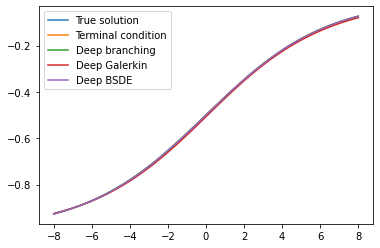

In [14]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.001
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-201913-allen_cahn-T0.125-nu1.0
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-202401-tmp


Time taken: 289 seconds; L1 error: 5.17E-04; L2 error: 4.57E-07; rel error: 1.60E-03.
fdb runtime: 0 seconds; total runtime: 289 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 245 seconds; L1 error: 6.22E-03; L2 error: 5.28E-05; rel error: 1.60E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-203206-allen_cahn-T0.125-nu1.0


Time taken: 240 seconds; L1 error: 1.22E-03; L2 error: 2.39E-06; rel error: 4.91E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-203654-tmp


Time taken: 288 seconds; L1 error: 1.14E-03; L2 error: 1.92E-06; rel error: 5.16E-03.
fdb runtime: 0 seconds; total runtime: 288 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 253 seconds; L1 error: 2.28E-03; L2 error: 6.89E-06; rel error: 9.44E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-204504-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 1.32E-03; L2 error: 2.23E-06; rel error: 4.30E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-204942-tmp


Time taken: 277 seconds; L1 error: 1.56E-03; L2 error: 3.70E-06; rel error: 3.42E-03.
fdb runtime: 0 seconds; total runtime: 277 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 255 seconds; L1 error: 7.26E-03; L2 error: 6.00E-05; rel error: 2.39E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-205753-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 1.11E-03; L2 error: 1.98E-06; rel error: 3.61E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-210228-tmp


Time taken: 275 seconds; L1 error: 1.17E-03; L2 error: 1.85E-06; rel error: 3.89E-03.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 246 seconds; L1 error: 7.58E-03; L2 error: 6.24E-05; rel error: 2.37E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-211031-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 9.34E-04; L2 error: 1.18E-06; rel error: 2.54E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-211509-tmp


Time taken: 278 seconds; L1 error: 9.13E-04; L2 error: 9.65E-07; rel error: 2.04E-03.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 256 seconds; L1 error: 7.97E-03; L2 error: 7.76E-05; rel error: 2.99E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-212322-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 1.43E-03; L2 error: 2.99E-06; rel error: 5.13E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-212807-tmp


Time taken: 285 seconds; L1 error: 5.49E-04; L2 error: 4.73E-07; rel error: 2.53E-03.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 265 seconds; L1 error: 1.30E-02; L2 error: 2.25E-04; rel error: 4.78E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-213630-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 5.78E-04; L2 error: 5.72E-07; rel error: 1.22E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-214058-tmp


Time taken: 269 seconds; L1 error: 3.64E-04; L2 error: 2.60E-07; rel error: 7.44E-04.
fdb runtime: 0 seconds; total runtime: 269 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 247 seconds; L1 error: 4.93E-03; L2 error: 2.86E-05; rel error: 1.68E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-214903-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 5.42E-04; L2 error: 4.53E-07; rel error: 1.55E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-215342-tmp


Time taken: 280 seconds; L1 error: 6.25E-04; L2 error: 5.86E-07; rel error: 2.22E-03.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 253 seconds; L1 error: 8.34E-03; L2 error: 9.53E-05; rel error: 2.95E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-220153-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 7.60E-04; L2 error: 9.17E-07; rel error: 2.76E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-220631-tmp


Time taken: 278 seconds; L1 error: 6.70E-04; L2 error: 6.42E-07; rel error: 2.10E-03.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 251 seconds; L1 error: 2.25E-03; L2 error: 8.53E-06; rel error: 1.06E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-221439-allen_cahn-T0.125-nu1.0


Time taken: 237 seconds; L1 error: 1.14E-03; L2 error: 2.14E-06; rel error: 4.12E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-221917-tmp


Time taken: 278 seconds; L1 error: 3.78E-04; L2 error: 1.93E-07; rel error: 1.18E-03.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 226 seconds; L1 error: 9.46E-03; L2 error: 1.31E-04; rel error: 2.20E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 8.99E-04; L2 error: 1.21E-06; rel error: 2.84E-03.




######## Summary for deep branching method
runtime:        280
fdb runtime:    0
total runtime:  280
mean L1 error:  7.89E-04
std L1 error:   3.74E-04
mean L2 error:  1.11E-06
std L2 error:   1.04E-06
mean rel error: 2.49E-03
std rel error:  1.26E-03


######## Summary for deep galerkin method
runtime:        250
mean L1 error:  6.93E-03
std L1 error:   3.08E-03
mean L2 error:  7.48E-05
std L2 error:   6.18E-05
mean rel error: 2.30E-02
std rel error:  1.06E-02


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  9.94E-04
std 

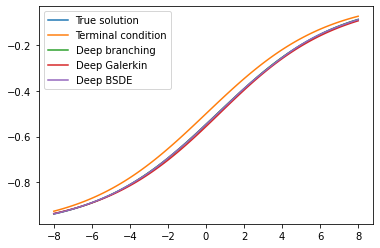

In [6]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.125
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-222700-allen_cahn-T0.25-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-223140-tmp


Time taken: 281 seconds; L1 error: 6.58E-04; L2 error: 7.60E-07; rel error: 1.71E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 246 seconds; L1 error: 6.50E-03; L2 error: 5.96E-05; rel error: 1.48E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-223943-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 2.04E-03; L2 error: 6.47E-06; rel error: 4.85E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-224426-tmp


Time taken: 283 seconds; L1 error: 1.83E-03; L2 error: 4.42E-06; rel error: 6.82E-03.
fdb runtime: 0 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 258 seconds; L1 error: 2.85E-03; L2 error: 1.08E-05; rel error: 9.68E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-225241-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 1.84E-03; L2 error: 5.11E-06; rel error: 6.22E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-225715-tmp


Time taken: 274 seconds; L1 error: 1.17E-03; L2 error: 3.21E-06; rel error: 1.74E-03.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 254 seconds; L1 error: 7.66E-03; L2 error: 7.00E-05; rel error: 2.24E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-230526-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 2.15E-03; L2 error: 7.56E-06; rel error: 7.57E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-231006-tmp


Time taken: 280 seconds; L1 error: 1.59E-03; L2 error: 3.34E-06; rel error: 4.72E-03.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 255 seconds; L1 error: 7.36E-03; L2 error: 5.89E-05; rel error: 2.12E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-231818-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 2.38E-03; L2 error: 8.65E-06; rel error: 5.71E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-232259-tmp


Time taken: 281 seconds; L1 error: 1.28E-03; L2 error: 2.14E-06; rel error: 2.85E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 266 seconds; L1 error: 9.07E-03; L2 error: 1.03E-04; rel error: 2.83E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-233122-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 2.03E-03; L2 error: 6.54E-06; rel error: 4.28E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-233607-tmp


Time taken: 285 seconds; L1 error: 1.96E-03; L2 error: 5.79E-06; rel error: 4.29E-03.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 255 seconds; L1 error: 1.28E-02; L2 error: 2.19E-04; rel error: 4.00E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-234418-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 1.69E-03; L2 error: 4.34E-06; rel error: 3.99E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-234847-tmp


Time taken: 268 seconds; L1 error: 7.85E-04; L2 error: 8.10E-07; rel error: 1.78E-03.
fdb runtime: 0 seconds; total runtime: 268 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 250 seconds; L1 error: 5.87E-03; L2 error: 4.20E-05; rel error: 1.77E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230420-235654-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 1.54E-03; L2 error: 3.22E-06; rel error: 4.24E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-000133-tmp


Time taken: 279 seconds; L1 error: 1.04E-03; L2 error: 1.29E-06; rel error: 2.41E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 262 seconds; L1 error: 8.28E-03; L2 error: 1.15E-04; rel error: 1.96E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-000952-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 1.79E-03; L2 error: 4.53E-06; rel error: 4.70E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-001427-tmp


Time taken: 275 seconds; L1 error: 1.01E-03; L2 error: 1.48E-06; rel error: 2.24E-03.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 255 seconds; L1 error: 2.86E-03; L2 error: 1.07E-05; rel error: 1.02E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-002239-allen_cahn-T0.25-nu1.0


Time taken: 237 seconds; L1 error: 2.00E-03; L2 error: 6.84E-06; rel error: 5.83E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-002721-tmp


Time taken: 282 seconds; L1 error: 6.64E-04; L2 error: 7.25E-07; rel error: 2.16E-03.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 258 seconds; L1 error: 1.07E-02; L2 error: 1.60E-04; rel error: 2.35E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 1.99E-03; L2 error: 6.36E-06; rel error: 7.19E-03.




######## Summary for deep branching method
runtime:        279
fdb runtime:    0
total runtime:  279
mean L1 error:  1.20E-03
std L1 error:   4.42E-04
mean L2 error:  2.40E-06
std L2 error:   1.65E-06
mean rel error: 3.07E-03
std rel error:  1.60E-03


######## Summary for deep galerkin method
runtime:        256
mean L1 error:  7.39E-03
std L1 error:   2.97E-03
mean L2 error:  8.49E-05
std L2 error:   6.26E-05
mean rel error: 2.07E-02
std rel error:  8.48E-03


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  1.95E-03
std 

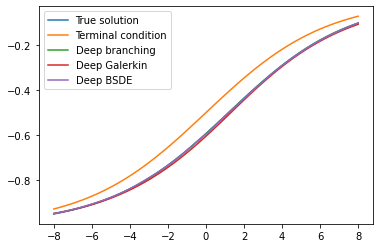

In [7]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.25
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-003537-allen_cahn-T0.375-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-004016-tmp


Time taken: 280 seconds; L1 error: 1.50E-03; L2 error: 3.67E-06; rel error: 2.64E-03.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 242 seconds; L1 error: 6.82E-03; L2 error: 6.72E-05; rel error: 1.40E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-004816-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.09E-03; L2 error: 1.27E-05; rel error: 7.19E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-005257-tmp


Time taken: 281 seconds; L1 error: 2.24E-03; L2 error: 7.05E-06; rel error: 5.62E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 258 seconds; L1 error: 3.45E-03; L2 error: 1.60E-05; rel error: 9.80E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-010112-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 2.88E-03; L2 error: 1.06E-05; rel error: 6.95E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-010548-tmp


Time taken: 276 seconds; L1 error: 2.10E-03; L2 error: 8.85E-06; rel error: 2.97E-03.
fdb runtime: 0 seconds; total runtime: 276 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 254 seconds; L1 error: 7.92E-03; L2 error: 8.41E-05; rel error: 2.16E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-011359-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.31E-03; L2 error: 1.52E-05; rel error: 8.35E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-011835-tmp


Time taken: 276 seconds; L1 error: 2.37E-03; L2 error: 7.16E-06; rel error: 4.72E-03.
fdb runtime: 0 seconds; total runtime: 276 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 244 seconds; L1 error: 7.32E-03; L2 error: 5.84E-05; rel error: 1.88E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-012635-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 2.96E-03; L2 error: 1.37E-05; rel error: 7.43E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-013116-tmp


Time taken: 281 seconds; L1 error: 2.04E-03; L2 error: 6.57E-06; rel error: 3.56E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 243 seconds; L1 error: 1.03E-02; L2 error: 1.39E-04; rel error: 2.76E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-013916-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.91E-03; L2 error: 3.06E-05; rel error: 9.35E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-014401-tmp


Time taken: 285 seconds; L1 error: 1.96E-03; L2 error: 6.19E-06; rel error: 7.25E-03.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 265 seconds; L1 error: 1.26E-02; L2 error: 2.12E-04; rel error: 3.36E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-015224-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.40E-03; L2 error: 1.48E-05; rel error: 8.36E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-015658-tmp


Time taken: 274 seconds; L1 error: 1.69E-03; L2 error: 4.16E-06; rel error: 3.23E-03.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 264 seconds; L1 error: 6.54E-03; L2 error: 5.74E-05; rel error: 1.70E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-020519-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.40E-03; L2 error: 1.63E-05; rel error: 1.03E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-020954-tmp


Time taken: 275 seconds; L1 error: 1.81E-03; L2 error: 4.93E-06; rel error: 3.17E-03.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 267 seconds; L1 error: 1.06E-02; L2 error: 2.12E-04; rel error: 1.71E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-021818-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.79E-03; L2 error: 2.03E-05; rel error: 9.13E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-022253-tmp


Time taken: 275 seconds; L1 error: 2.11E-03; L2 error: 6.18E-06; rel error: 5.00E-03.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 255 seconds; L1 error: 3.58E-03; L2 error: 1.58E-05; rel error: 1.00E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-023105-allen_cahn-T0.375-nu1.0


Time taken: 237 seconds; L1 error: 3.57E-03; L2 error: 1.95E-05; rel error: 8.81E-03.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-023547-tmp


Time taken: 283 seconds; L1 error: 1.80E-03; L2 error: 4.21E-06; rel error: 3.98E-03.
fdb runtime: 0 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 257 seconds; L1 error: 1.16E-02; L2 error: 1.87E-04; rel error: 2.42E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 3.66E-03; L2 error: 1.97E-05; rel error: 1.02E-02.




######## Summary for deep branching method
runtime:        279
fdb runtime:    0
total runtime:  279
mean L1 error:  1.96E-03
std L1 error:   2.51E-04
mean L2 error:  5.90E-06
std L2 error:   1.55E-06
mean rel error: 4.21E-03
std rel error:  1.37E-03


######## Summary for deep galerkin method
runtime:        255
mean L1 error:  8.07E-03
std L1 error:   3.01E-03
mean L2 error:  1.05E-04
std L2 error:   7.28E-05
mean rel error: 1.94E-02
std rel error:  7.20E-03


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  3.40E-03
std 

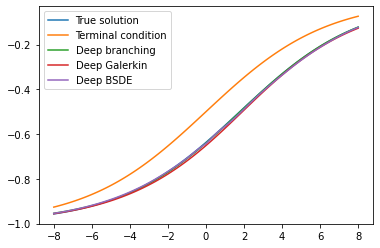

In [8]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.375
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-024402-allen_cahn-T0.5-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-024841-tmp


Time taken: 279 seconds; L1 error: 3.31E-03; L2 error: 1.68E-05; rel error: 5.06E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 255 seconds; L1 error: 7.23E-03; L2 error: 7.61E-05; rel error: 1.36E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-025653-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.45E-03; L2 error: 3.99E-05; rel error: 1.27E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-030136-tmp


Time taken: 282 seconds; L1 error: 4.46E-03; L2 error: 2.80E-05; rel error: 8.35E-03.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 247 seconds; L1 error: 4.71E-03; L2 error: 2.58E-05; rel error: 1.13E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-030940-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 4.51E-03; L2 error: 2.58E-05; rel error: 1.07E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-031414-tmp


Time taken: 274 seconds; L1 error: 4.04E-03; L2 error: 2.79E-05; rel error: 5.73E-03.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 261 seconds; L1 error: 8.94E-03; L2 error: 1.12E-04; rel error: 2.22E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-032232-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.44E-03; L2 error: 4.08E-05; rel error: 1.43E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-032712-tmp


Time taken: 279 seconds; L1 error: 3.92E-03; L2 error: 2.45E-05; rel error: 6.10E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 256 seconds; L1 error: 7.33E-03; L2 error: 5.87E-05; rel error: 1.67E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-033525-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 4.89E-03; L2 error: 3.06E-05; rel error: 1.14E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-034002-tmp


Time taken: 277 seconds; L1 error: 3.87E-03; L2 error: 2.33E-05; rel error: 6.52E-03.
fdb runtime: 0 seconds; total runtime: 277 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 247 seconds; L1 error: 1.15E-02; L2 error: 1.82E-04; rel error: 2.75E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-034806-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.47E-03; L2 error: 3.81E-05; rel error: 1.20E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-035250-tmp


Time taken: 283 seconds; L1 error: 3.51E-03; L2 error: 1.51E-05; rel error: 7.56E-03.
fdb runtime: 0 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 254 seconds; L1 error: 1.22E-02; L2 error: 2.03E-04; rel error: 2.85E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-040101-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.73E-03; L2 error: 4.04E-05; rel error: 1.44E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-040528-tmp


Time taken: 267 seconds; L1 error: 3.98E-03; L2 error: 2.31E-05; rel error: 7.09E-03.
fdb runtime: 0 seconds; total runtime: 267 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 259 seconds; L1 error: 7.01E-03; L2 error: 7.73E-05; rel error: 1.55E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-041343-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.69E-03; L2 error: 3.97E-05; rel error: 1.34E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-041822-tmp


Time taken: 279 seconds; L1 error: 4.11E-03; L2 error: 2.67E-05; rel error: 6.53E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 249 seconds; L1 error: 1.11E-02; L2 error: 2.28E-04; rel error: 1.71E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-042629-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.19E-03; L2 error: 4.73E-05; rel error: 1.11E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-043107-tmp


Time taken: 279 seconds; L1 error: 4.28E-03; L2 error: 2.65E-05; rel error: 7.54E-03.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 264 seconds; L1 error: 4.34E-03; L2 error: 2.43E-05; rel error: 1.01E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-043928-allen_cahn-T0.5-nu1.0


Time taken: 237 seconds; L1 error: 5.63E-03; L2 error: 5.31E-05; rel error: 1.33E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-044410-tmp


Time taken: 281 seconds; L1 error: 3.83E-03; L2 error: 2.14E-05; rel error: 7.37E-03.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 266 seconds; L1 error: 1.23E-02; L2 error: 2.09E-04; rel error: 2.39E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 5.05E-03; L2 error: 3.52E-05; rel error: 1.32E-02.




######## Summary for deep branching method
runtime:        278
fdb runtime:    0
total runtime:  278
mean L1 error:  3.93E-03
std L1 error:   3.20E-04
mean L2 error:  2.33E-05
std L2 error:   4.23E-06
mean rel error: 6.78E-03
std rel error:  9.35E-04


######## Summary for deep galerkin method
runtime:        256
mean L1 error:  8.67E-03
std L1 error:   2.85E-03
mean L2 error:  1.20E-04
std L2 error:   7.48E-05
mean rel error: 1.87E-02
std rel error:  6.19E-03


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  5.31E-03
std 

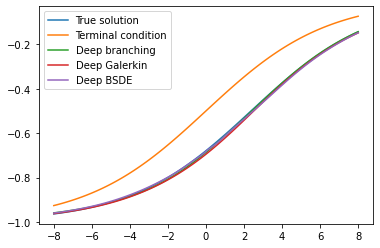

In [9]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-045233-allen_cahn-T0.625-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-045713-tmp


Time taken: 280 seconds; L1 error: 6.94E-03; L2 error: 7.20E-05; rel error: 1.02E-02.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 248 seconds; L1 error: 7.66E-03; L2 error: 8.52E-05; rel error: 1.33E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-050518-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.36E-03; L2 error: 7.45E-05; rel error: 1.63E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-050959-tmp


Time taken: 281 seconds; L1 error: 7.28E-03; L2 error: 8.93E-05; rel error: 1.06E-02.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 260 seconds; L1 error: 4.89E-03; L2 error: 3.39E-05; rel error: 1.04E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-051816-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.62E-03; L2 error: 7.98E-05; rel error: 1.79E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-052250-tmp


Time taken: 274 seconds; L1 error: 6.95E-03; L2 error: 8.09E-05; rel error: 9.85E-03.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 256 seconds; L1 error: 1.04E-02; L2 error: 1.55E-04; rel error: 2.28E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-053103-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 8.08E-03; L2 error: 9.00E-05; rel error: 1.83E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-053541-tmp


Time taken: 278 seconds; L1 error: 7.36E-03; L2 error: 8.70E-05; rel error: 1.12E-02.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 265 seconds; L1 error: 7.48E-03; L2 error: 6.13E-05; rel error: 1.51E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-054403-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.13E-03; L2 error: 6.98E-05; rel error: 1.62E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-054844-tmp


Time taken: 281 seconds; L1 error: 6.84E-03; L2 error: 7.15E-05; rel error: 1.06E-02.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 253 seconds; L1 error: 1.28E-02; L2 error: 2.31E-04; rel error: 2.78E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-055654-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.84E-03; L2 error: 8.18E-05; rel error: 1.91E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-060135-tmp


Time taken: 281 seconds; L1 error: 7.22E-03; L2 error: 6.82E-05; rel error: 1.29E-02.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 264 seconds; L1 error: 1.18E-02; L2 error: 1.93E-04; rel error: 2.44E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-060956-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.55E-03; L2 error: 8.09E-05; rel error: 1.67E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-061426-tmp


Time taken: 270 seconds; L1 error: 6.90E-03; L2 error: 7.16E-05; rel error: 1.08E-02.
fdb runtime: 0 seconds; total runtime: 270 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 266 seconds; L1 error: 7.51E-03; L2 error: 1.03E-04; rel error: 1.41E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-062249-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 7.75E-03; L2 error: 8.48E-05; rel error: 1.82E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-062729-tmp


Time taken: 280 seconds; L1 error: 7.29E-03; L2 error: 7.94E-05; rel error: 1.19E-02.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 257 seconds; L1 error: 1.15E-02; L2 error: 2.44E-04; rel error: 1.73E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-063543-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 8.15E-03; L2 error: 8.49E-05; rel error: 1.90E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-064022-tmp


Time taken: 279 seconds; L1 error: 7.65E-03; L2 error: 8.77E-05; rel error: 1.15E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 259 seconds; L1 error: 5.18E-03; L2 error: 3.60E-05; rel error: 1.05E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-064838-allen_cahn-T0.625-nu1.0


Time taken: 237 seconds; L1 error: 8.53E-03; L2 error: 9.39E-05; rel error: 2.00E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-065316-tmp


Time taken: 279 seconds; L1 error: 7.02E-03; L2 error: 8.05E-05; rel error: 1.14E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 253 seconds; L1 error: 1.29E-02; L2 error: 2.27E-04; rel error: 2.33E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 7.72E-03; L2 error: 9.11E-05; rel error: 1.66E-02.




######## Summary for deep branching method
runtime:        278
fdb runtime:    0
total runtime:  278
mean L1 error:  7.15E-03
std L1 error:   2.45E-04
mean L2 error:  7.88E-05
std L2 error:   7.26E-06
mean rel error: 1.11E-02
std rel error:  8.24E-04


######## Summary for deep galerkin method
runtime:        258
mean L1 error:  9.20E-03
std L1 error:   2.88E-03
mean L2 error:  1.37E-04
std L2 error:   7.88E-05
mean rel error: 1.79E-02
std rel error:  5.91E-03


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  7.77E-03
std 

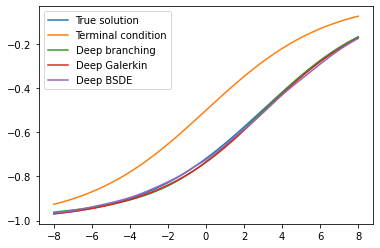

In [10]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.625
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-070126-allen_cahn-T0.75-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-070605-tmp


Time taken: 278 seconds; L1 error: 1.13E-02; L2 error: 1.94E-04; rel error: 1.61E-02.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 258 seconds; L1 error: 8.09E-03; L2 error: 9.43E-05; rel error: 1.31E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-071420-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.06E-02; L2 error: 1.48E-04; rel error: 2.32E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-071903-tmp


Time taken: 283 seconds; L1 error: 1.29E-02; L2 error: 2.67E-04; rel error: 1.80E-02.
fdb runtime: 0 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 256 seconds; L1 error: 5.45E-03; L2 error: 4.28E-05; rel error: 1.01E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-072716-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.06E-02; L2 error: 1.54E-04; rel error: 2.39E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-073150-tmp


Time taken: 274 seconds; L1 error: 1.17E-02; L2 error: 2.20E-04; rel error: 1.62E-02.
fdb runtime: 0 seconds; total runtime: 274 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 260 seconds; L1 error: 1.19E-02; L2 error: 2.06E-04; rel error: 2.39E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-074008-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.04E-02; L2 error: 1.47E-04; rel error: 2.25E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-074444-tmp


Time taken: 276 seconds; L1 error: 1.20E-02; L2 error: 2.29E-04; rel error: 1.77E-02.
fdb runtime: 0 seconds; total runtime: 276 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 250 seconds; L1 error: 7.74E-03; L2 error: 6.61E-05; rel error: 1.41E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-075251-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.01E-02; L2 error: 1.46E-04; rel error: 2.14E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-075727-tmp


Time taken: 276 seconds; L1 error: 1.13E-02; L2 error: 1.90E-04; rel error: 1.75E-02.
fdb runtime: 0 seconds; total runtime: 276 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 260 seconds; L1 error: 1.40E-02; L2 error: 2.80E-04; rel error: 2.81E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-080544-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.09E-02; L2 error: 1.57E-04; rel error: 2.35E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-081030-tmp


Time taken: 286 seconds; L1 error: 1.18E-02; L2 error: 1.91E-04; rel error: 1.86E-02.
fdb runtime: 0 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 261 seconds; L1 error: 1.14E-02; L2 error: 1.82E-04; rel error: 2.12E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-081848-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.05E-02; L2 error: 1.53E-04; rel error: 2.32E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-082311-tmp


Time taken: 264 seconds; L1 error: 1.17E-02; L2 error: 2.07E-04; rel error: 1.76E-02.
fdb runtime: 0 seconds; total runtime: 264 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 257 seconds; L1 error: 8.15E-03; L2 error: 1.31E-04; rel error: 1.34E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-083125-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.04E-02; L2 error: 1.41E-04; rel error: 2.21E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-083604-tmp


Time taken: 279 seconds; L1 error: 1.14E-02; L2 error: 2.02E-04; rel error: 1.66E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 239 seconds; L1 error: 1.22E-02; L2 error: 2.67E-04; rel error: 1.83E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-084400-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.12E-02; L2 error: 1.81E-04; rel error: 2.41E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-084839-tmp


Time taken: 279 seconds; L1 error: 1.28E-02; L2 error: 2.43E-04; rel error: 1.93E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 257 seconds; L1 error: 5.94E-03; L2 error: 5.36E-05; rel error: 1.03E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-085653-allen_cahn-T0.75-nu1.0


Time taken: 237 seconds; L1 error: 1.15E-02; L2 error: 1.90E-04; rel error: 2.69E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-090135-tmp


Time taken: 282 seconds; L1 error: 1.19E-02; L2 error: 2.28E-04; rel error: 1.80E-02.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 254 seconds; L1 error: 1.34E-02; L2 error: 2.42E-04; rel error: 2.26E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 237 seconds; L1 error: 1.05E-02; L2 error: 1.73E-04; rel error: 2.33E-02.




######## Summary for deep branching method
runtime:        278
fdb runtime:    0
total runtime:  278
mean L1 error:  1.19E-02
std L1 error:   5.47E-04
mean L2 error:  2.17E-04
std L2 error:   2.39E-05
mean rel error: 1.76E-02
std rel error:  9.65E-04


######## Summary for deep galerkin method
runtime:        255
mean L1 error:  9.82E-03
std L1 error:   2.94E-03
mean L2 error:  1.56E-04
std L2 error:   8.60E-05
mean rel error: 1.75E-02
std rel error:  5.90E-03


######## Summary for deep BSDE method
runtime:        237
mean L1 error:  1.07E-02
std 

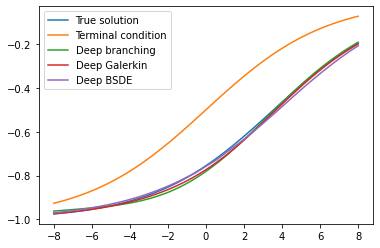

In [11]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.75
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-090946-allen_cahn-T0.875-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-091424-tmp


Time taken: 278 seconds; L1 error: 1.72E-02; L2 error: 4.47E-04; rel error: 2.36E-02.
fdb runtime: 0 seconds; total runtime: 278 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 245 seconds; L1 error: 8.44E-03; L2 error: 1.02E-04; rel error: 1.27E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-092227-allen_cahn-T0.875-nu1.0


Time taken: 238 seconds; L1 error: 1.37E-02; L2 error: 2.81E-04; rel error: 3.02E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-092713-tmp


Time taken: 286 seconds; L1 error: 2.02E-02; L2 error: 6.33E-04; rel error: 2.79E-02.
fdb runtime: 0 seconds; total runtime: 286 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 251 seconds; L1 error: 5.57E-03; L2 error: 4.89E-05; rel error: 8.91E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-093524-allen_cahn-T0.875-nu1.0


Time taken: 240 seconds; L1 error: 1.40E-02; L2 error: 3.07E-04; rel error: 2.94E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-094004-tmp


Time taken: 280 seconds; L1 error: 1.81E-02; L2 error: 5.09E-04; rel error: 2.46E-02.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 261 seconds; L1 error: 1.37E-02; L2 error: 2.59E-04; rel error: 2.36E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-094831-allen_cahn-T0.875-nu1.0


Time taken: 247 seconds; L1 error: 1.27E-02; L2 error: 2.38E-04; rel error: 2.60E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-095313-tmp


Time taken: 282 seconds; L1 error: 1.82E-02; L2 error: 5.39E-04; rel error: 2.48E-02.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 261 seconds; L1 error: 8.13E-03; L2 error: 7.35E-05; rel error: 1.37E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-100136-allen_cahn-T0.875-nu1.0


Time taken: 242 seconds; L1 error: 1.35E-02; L2 error: 2.77E-04; rel error: 2.79E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-100621-tmp


Time taken: 285 seconds; L1 error: 1.77E-02; L2 error: 4.53E-04; rel error: 2.51E-02.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 251 seconds; L1 error: 1.49E-02; L2 error: 3.25E-04; rel error: 2.81E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-101440-allen_cahn-T0.875-nu1.0


Time taken: 248 seconds; L1 error: 1.39E-02; L2 error: 2.78E-04; rel error: 2.97E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-101931-tmp


Time taken: 292 seconds; L1 error: 1.81E-02; L2 error: 4.55E-04; rel error: 2.70E-02.
fdb runtime: 0 seconds; total runtime: 292 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 260 seconds; L1 error: 1.10E-02; L2 error: 1.70E-04; rel error: 1.83E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-102750-allen_cahn-T0.875-nu1.0


Time taken: 239 seconds; L1 error: 1.36E-02; L2 error: 2.68E-04; rel error: 2.83E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-103226-tmp


Time taken: 275 seconds; L1 error: 1.77E-02; L2 error: 4.56E-04; rel error: 2.53E-02.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 226 seconds; L1 error: 9.06E-03; L2 error: 1.57E-04; rel error: 1.41E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-104011-allen_cahn-T0.875-nu1.0


Time taken: 240 seconds; L1 error: 1.28E-02; L2 error: 2.34E-04; rel error: 2.62E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-104453-tmp


Time taken: 282 seconds; L1 error: 1.74E-02; L2 error: 4.60E-04; rel error: 2.47E-02.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 225 seconds; L1 error: 1.31E-02; L2 error: 2.97E-04; rel error: 1.93E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-105239-allen_cahn-T0.875-nu1.0


Time taken: 241 seconds; L1 error: 1.32E-02; L2 error: 2.69E-04; rel error: 2.61E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-105722-tmp


Time taken: 283 seconds; L1 error: 1.90E-02; L2 error: 5.23E-04; rel error: 2.67E-02.
fdb runtime: 0 seconds; total runtime: 283 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 253 seconds; L1 error: 6.95E-03; L2 error: 7.54E-05; rel error: 1.10E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-110536-allen_cahn-T0.875-nu1.0


Time taken: 240 seconds; L1 error: 1.37E-02; L2 error: 2.77E-04; rel error: 2.79E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-111020-tmp


Time taken: 284 seconds; L1 error: 1.81E-02; L2 error: 5.33E-04; rel error: 2.55E-02.
fdb runtime: 0 seconds; total runtime: 284 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 250 seconds; L1 error: 1.38E-02; L2 error: 2.55E-04; rel error: 2.19E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 239 seconds; L1 error: 1.30E-02; L2 error: 2.62E-04; rel error: 2.80E-02.




######## Summary for deep branching method
runtime:        283
fdb runtime:    0
total runtime:  283
mean L1 error:  1.82E-02
std L1 error:   8.34E-04
mean L2 error:  5.01E-04
std L2 error:   5.61E-05
mean rel error: 2.55E-02
std rel error:  1.23E-03


######## Summary for deep galerkin method
runtime:        248
mean L1 error:  1.05E-02
std L1 error:   3.10E-03
mean L2 error:  1.76E-04
std L2 error:   9.62E-05
mean rel error: 1.72E-02
std rel error:  5.81E-03


######## Summary for deep BSDE method
runtime:        241
mean L1 error:  1.34E-02
std 

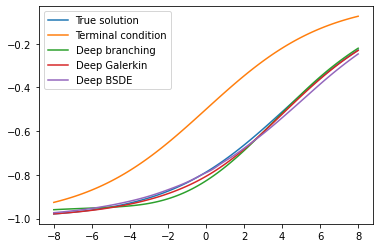

In [12]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.875
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-111829-allen_cahn-T1.0-nu1.0


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-112313-tmp


Time taken: 284 seconds; L1 error: 2.36E-02; L2 error: 8.50E-04; rel error: 3.12E-02.
fdb runtime: 0 seconds; total runtime: 284 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 256 seconds; L1 error: 8.74E-03; L2 error: 1.08E-04; rel error: 1.24E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-113128-allen_cahn-T1.0-nu1.0


Time taken: 239 seconds; L1 error: 1.58E-02; L2 error: 3.69E-04; rel error: 3.09E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-113613-tmp


Time taken: 285 seconds; L1 error: 2.81E-02; L2 error: 1.22E-03; rel error: 3.74E-02.
fdb runtime: 0 seconds; total runtime: 285 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 250 seconds; L1 error: 5.57E-03; L2 error: 5.97E-05; rel error: 8.27E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-114420-allen_cahn-T1.0-nu1.0


Time taken: 237 seconds; L1 error: 1.64E-02; L2 error: 4.27E-04; rel error: 3.29E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-114853-tmp


Time taken: 272 seconds; L1 error: 2.63E-02; L2 error: 1.06E-03; rel error: 3.49E-02.
fdb runtime: 0 seconds; total runtime: 272 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 252 seconds; L1 error: 1.55E-02; L2 error: 3.09E-04; rel error: 2.49E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-115703-allen_cahn-T1.0-nu1.0


Time taken: 239 seconds; L1 error: 1.60E-02; L2 error: 3.96E-04; rel error: 3.15E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-120142-tmp


Time taken: 279 seconds; L1 error: 2.56E-02; L2 error: 1.05E-03; rel error: 3.35E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 254 seconds; L1 error: 8.69E-03; L2 error: 8.42E-05; rel error: 1.36E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-120953-allen_cahn-T1.0-nu1.0


Time taken: 237 seconds; L1 error: 1.64E-02; L2 error: 4.14E-04; rel error: 3.28E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-121433-tmp


Time taken: 280 seconds; L1 error: 2.51E-02; L2 error: 8.91E-04; rel error: 3.46E-02.
fdb runtime: 0 seconds; total runtime: 280 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 257 seconds; L1 error: 1.55E-02; L2 error: 3.60E-04; rel error: 2.76E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-122247-allen_cahn-T1.0-nu1.0


Time taken: 237 seconds; L1 error: 1.66E-02; L2 error: 4.29E-04; rel error: 3.32E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-122729-tmp


Time taken: 282 seconds; L1 error: 2.68E-02; L2 error: 1.02E-03; rel error: 3.77E-02.
fdb runtime: 0 seconds; total runtime: 282 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 247 seconds; L1 error: 1.06E-02; L2 error: 1.60E-04; rel error: 1.59E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-123533-allen_cahn-T1.0-nu1.0


Time taken: 237 seconds; L1 error: 1.64E-02; L2 error: 4.15E-04; rel error: 3.26E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-124009-tmp


Time taken: 275 seconds; L1 error: 2.57E-02; L2 error: 1.00E-03; rel error: 3.44E-02.
fdb runtime: 0 seconds; total runtime: 275 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 266 seconds; L1 error: 1.05E-02; L2 error: 1.94E-04; rel error: 1.60E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-124833-allen_cahn-T1.0-nu1.0


Time taken: 239 seconds; L1 error: 1.62E-02; L2 error: 4.20E-04; rel error: 3.22E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-125314-tmp


Time taken: 281 seconds; L1 error: 2.50E-02; L2 error: 9.48E-04; rel error: 3.41E-02.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 245 seconds; L1 error: 1.40E-02; L2 error: 3.31E-04; rel error: 2.03E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-130121-allen_cahn-T1.0-nu1.0


Time taken: 241 seconds; L1 error: 1.60E-02; L2 error: 3.87E-04; rel error: 3.14E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-130602-tmp


Time taken: 281 seconds; L1 error: 2.81E-02; L2 error: 1.14E-03; rel error: 3.80E-02.
fdb runtime: 0 seconds; total runtime: 281 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 251 seconds; L1 error: 7.65E-03; L2 error: 9.49E-05; rel error: 1.10E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-131413-allen_cahn-T1.0-nu1.0


Time taken: 240 seconds; L1 error: 1.53E-02; L2 error: 3.58E-04; rel error: 2.99E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/20230421-131853-tmp


Time taken: 279 seconds; L1 error: 2.65E-02; L2 error: 1.10E-03; rel error: 3.56E-02.
fdb runtime: 0 seconds; total runtime: 279 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 256 seconds; L1 error: 1.41E-02; L2 error: 2.67E-04; rel error: 2.12E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 243 seconds; L1 error: 1.67E-02; L2 error: 4.68E-04; rel error: 3.46E-02.




######## Summary for deep branching method
runtime:        280
fdb runtime:    0
total runtime:  280
mean L1 error:  2.61E-02
std L1 error:   1.33E-03
mean L2 error:  1.03E-03
std L2 error:   1.06E-04
mean rel error: 3.51E-02
std rel error:  2.00E-03


######## Summary for deep galerkin method
runtime:        253
mean L1 error:  1.11E-02
std L1 error:   3.33E-03
mean L2 error:  1.97E-04
std L2 error:   1.06E-04
mean rel error: 1.71E-02
std rel error:  5.91E-03


######## Summary for deep BSDE method
runtime:        239
mean L1 error:  1.62E-02
std 

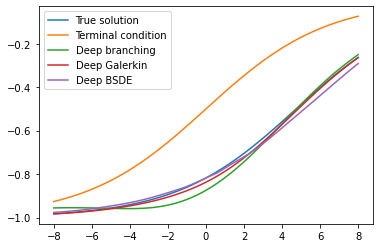

In [13]:
fixed_dim, dim = 0, 10
deriv_map = np.array([0] * dim).reshape(-1, dim)
dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1.0
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=80000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=200000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)